# Modelo Ciclo-De-Vida-Mosquitos-Huevos.

Este modelo busca predecir el comportamiento de los mosquitos $V_s$ teniendo en cuenta los huevos mediante los datos de precipitaciones.

El modelo utiliza los parámetros:
* $\Lambda_v$: Tasa de natalidad de los mosquitos. Este parámetro dependerá de la temperatura.
* $\mu_v$: Tasa de mortalidad de los mosquitos.
* $\mu_h$: Tasa de mortalidad de los huevos.

Luego, las ecuaciones diferenciales serán algo del estilo:

* $\frac{dV_s}{d_t} = k * λ_v(t)*V_s*H - μ_v * V_s$
* $\frac{dH}{d_t} = α(L,T)*H - μ_h*H$
* $\frac{dL}{d_t} = \frac{1}{7}*(P(t) - L)$

In [127]:
#from google.colab import files
#uploaded = files.upload()

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy.integrate import odeint

In [129]:
clima5Y = pd.read_csv(
    'ClimaServicio5YRosario.csv',
    na_values='\\N'    # convierte '\N' en NaN
)

clima5Y['TMED'] = clima5Y['TMED'].ffill()
tmed5Y = np.array(clima5Y['TMED'], dtype=float)
clima5Y['PRECIP'] = clima5Y['PRECIP'].ffill()
precip5Y = np.array(clima5Y['PRECIP'], dtype=float)
lenClima5Y = len(clima5Y)
print(lenClima5Y)
print(tmed5Y)
print(precip5Y)


2131
[23.5        22.89999962 24.5        ... 13.30000019 16.10000038
 18.79999924]
[0. 0. 0. ... 0. 0. 0.]


# Modelo.

Por problemas del minimize luego en la parte de búsqueda de parámetros, conviene reemplazar $(H_s + H_i + H_r)$ por $N_h$.

De lo contrario por el funcionamiento interno de minimize, cada uno de esos compartimentos decrece demasiado y termina dividiendo por cero.



In [130]:
def CicloMosquitos_model(x,t):

    #k = 0.356
    #j = 0.356

    k = 1
    j = 1
    Hm = 1e6 # Este parámetro es el número máximo de huevos (limitado por factores ambientales, humanos, etc)
    T= Temp(t) #temperatura

    # Desarmamos el vector
    Vs, H, L = x
    # Planteamos la ecuacion
    # alpha(t,L) devuelve una función que depende de la temperatura y la lluvia.
    dVs_dt = k*alpha(T,L) * H - mu_v * Vs  # alpha: Tasa de eclosión (respecto de la Temperatura y Nivel de Agua)
                                             # mu_v: Tasa de mortalidad (parámetro fijo)
    dH_dt = j* lam_v(T) * Vs * (1-H/Hm) - k*alpha(T,L) * H - mu_h * H  #lam_v es la tasa de ovoposición dependiente de la temperatura
    dL_dt = 1/7 * (P(t) - L)

    return [dVs_dt, dH_dt, dL_dt]

# Parámetros.

In [131]:
# Parameters

mu_v = 1/10 # Tasa de mortalidad de los mosquitos. Se busca que sea aprox. 20 días.
mu_h = 1/150 # Tasa de mortalidad de los huevos.

lmin = 0
lmax = 15

tmin = 20
tmax = 30

tminHuevos = 23
tmaxHuevos = 28

# Alpha es la tasa de nacimiento de los huevos.
# Es el producto de dos funciones acumuladas alpha1(T)*alpha2(L),
# una depende de la temperatura y la otra del tiempo.
def alpha(T,L):
  return alpha1(L) * THuevos(T) # (alpha2)


def alpha1(L):

  # Si L es menor que pmin retorno 0
  if L <= lmin:
    return 0

  # Si L es mayor que pmax retorno 1
  if L >= lmax:
    return 1

  # Si está en el medio tiene que dar algo lineal
  return max (1 - abs ((L - lmax) / lmax) , 0)

# Precipitaciones
def P(t):
  index = int(np.floor(t))

  if index > len(precip5Y) - 1:
    return 0

  return precip5Y[index]

def THuevos(T):
  return max (1 - abs ((T - tmaxHuevos) / (tmaxHuevos - tminHuevos)) , 0)


def lam_v(T):
  return max (1 - abs ((T - tmax) / (tmax-tmin)) , 0)

def Temp(t): #returns the temperature at day t
  index = int(np.floor(t))

  if index > lenClima5Y - 1:
    return tmed5Y[lenClima5Y - 1]

  return tmed5Y[index]



# Condiciones iniciales.

In [132]:
# Initial conditions

Nv = 1000 # Total población de mosquitos
Vs_0 = Nv # Total mosquitos susceptibles
H = 1000 # Huevos iniciales
L = 0   # Lluvia inicial, (ver que valor inicial iria)

x0 = [Vs_0, H, L] # Vector inicial

# Simulación del tiempo.

In [133]:
# Time solution -> Básicamente genera el eje x.
t_start = 0.0
t_end = lenClima5Y - 1 # Seis años
num_points = lenClima5Y # 1:1 para que se correspondan con los días
time_points = np.linspace(t_start, t_end, num_points) # Genera lenClimaRos5Y puntos entre 0 y lenClimaRos5Y - 1  equiespaciados.

# Cálculo de soluciones.

In [134]:
params = [lam_v, mu_v, mu_h, alpha, P]
sol = odeint(CicloMosquitos_model, x0, time_points,rtol=1e-3, atol=1e-6)

Vs = sol[:, 0]
H =  sol[:, 1]
L =  sol[:, 2]

#print(len(Vs))
#print("-----------------")
#print(len(L))

# Ploteo.

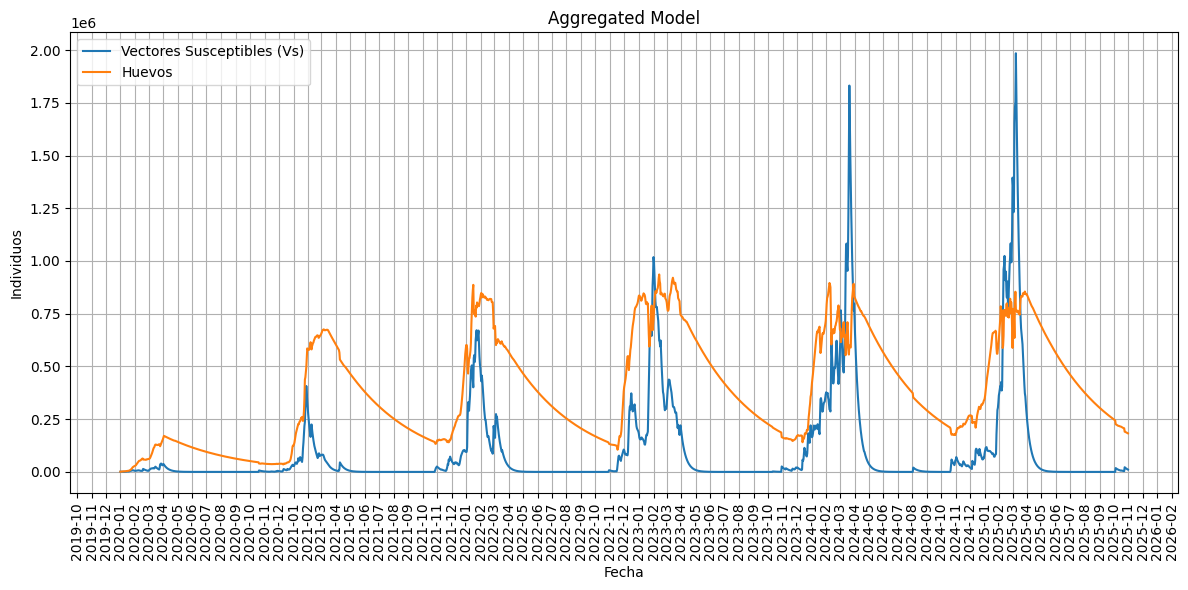

In [135]:
# Generar eje de fechas real
start_date = "2020-01-01"
date_index = pd.date_range(start=start_date, periods=lenClima5Y, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(date_index, Vs, label='Vectores Susceptibles (Vs)')
plt.plot(date_index, H, label='Huevos')

plt.title('Aggregated Model')
plt.xlabel('Fecha')
plt.ylabel('Individuos')
plt.grid(True)
plt.legend()

# ---- FORMATO DEL EJE X ----

# Mostrar solo meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)  # inclinamos las fechas
plt.tight_layout()
plt.show()
